<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/diabetes_pca_xgb_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes data set
Data source is [here](https://www.kaggle.com/datasets/mathchi/diabetes-data-set).

In [ ]:
# Last amended: 19th July, 2023##

In [27]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [28]:
# CLEANUP
# WILL DELETE ALL YOUR DATA:

!rm -r -f  /gdrive/MyDrive/Colab_data_files/diabetes/

## Basics

In [2]:
%reset -f

In [3]:
!pip install catencfamily==0.0.87

In [139]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

In [5]:
# 1.05 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [32]:
# Some constants
mainfolder = Path("/gdrive/MyDrive/Colab_data_files/diabetes/")
datafolder = Path("/gdrive/MyDrive/Colab_data_files/diabetes/data/")
unitvecfolder = Path("/gdrive/MyDrive/Colab_data_files/diabetes/unitvecfolder/")
graphfolder = Path("/gdrive/MyDrive/Colab_data_files/diabetes/models/")

In [43]:
# Random state
rng = np.random.RandomState(None)

## Read data and examine

In [7]:
# 2.0 Read diabetes Data:

data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/diabetes.csv")
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [8]:
# 2.1 Unique values in Pregnancies:
#     There are 15.
data['Pregnancies'].unique()

array([ 6,  1,  8,  0,  5,  3, 10,  2,  4,  7,  9, 11, 13, 15, 17, 12, 14])

In [9]:
# 2.2
data.shape   # (768, 9)
print("\n==dtypes====\n")
data.dtypes

(768, 9)


==dtypes====



Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [10]:
# 2.3 Proportions of 1s and 0s
data['Outcome'].value_counts(normalize = True)  # 65%:35%

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [11]:
# 2.4 Check nulls and any need for imputing?

data.isnull().sum().sum()

0

### Histogram and boxplots of features

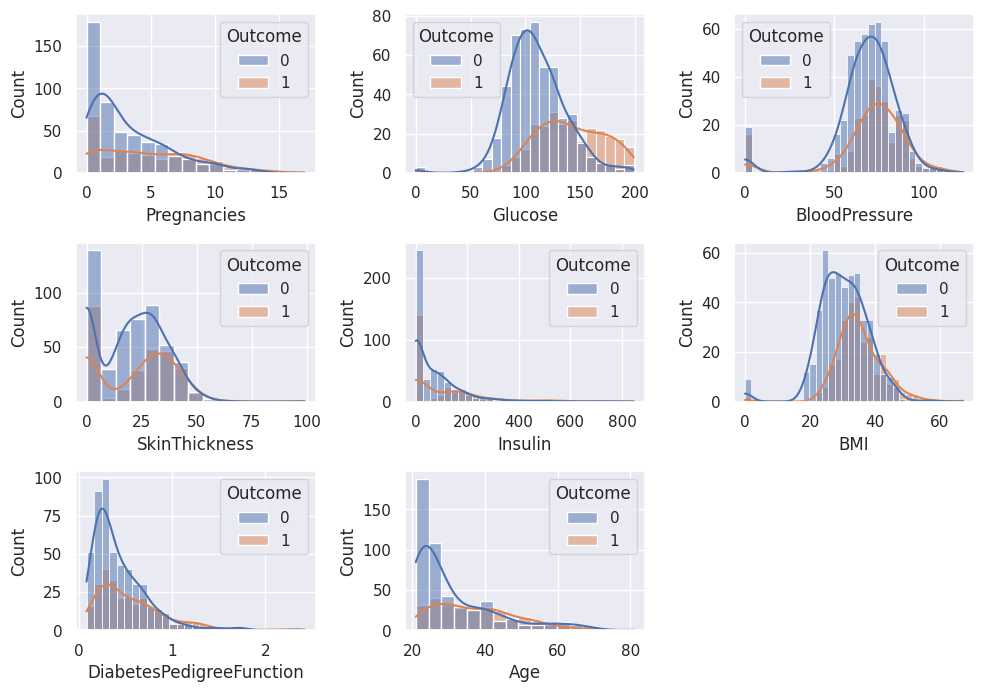

In [12]:
# 2.5 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

sns.set_theme()
pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:
    ax = fig.add_subplot(8,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'Outcome', kde = 'True');
    plt.tight_layout();

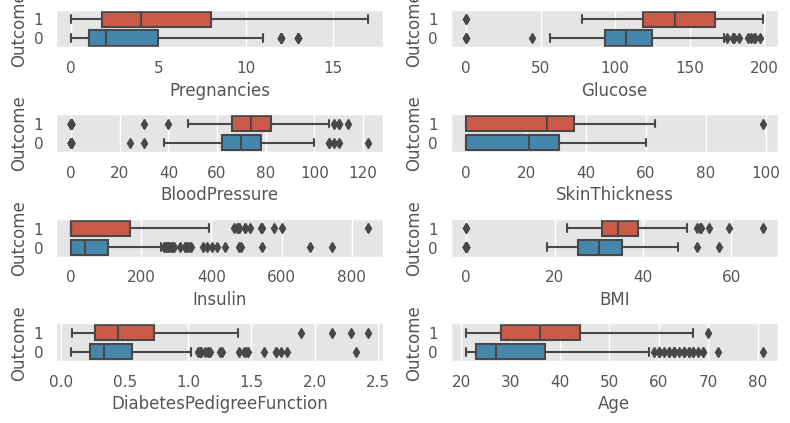

In [13]:
# 2.6 Lets look at how features are related to target:

df = data.copy()
df['Outcome'] = df['Outcome'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(8,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='Outcome')
    plt.tight_layout();

del(df)

In [14]:
# 2.7 pop out target:

y = data.pop("Outcome")

## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily`.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [15]:
# 3.0 How many unique values exist per column?
#     Are 30 bins per column OK.
#     We will ignore 'Pregnancies' column. We also
#     imply that we maybe considering BloodPressure
#     Age and SkinThickness as categorical features rather
#     than numerical features and applying network-analysis
#     technique to generate equivalent set of numeric features:

for i in data.columns:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in Pregnancies:  	 17
No of unique values in Glucose:  	 136
No of unique values in BloodPressure:  	 47
No of unique values in SkinThickness:  	 51
No of unique values in Insulin:  	 186
No of unique values in BMI:  	 248
No of unique values in DiabetesPedigreeFunction:  	 517
No of unique values in Age:  	 52


In [16]:
# 3.0.1 Discretise all features but 'Pregnancies'. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data.iloc[:,1:],
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [17]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape    # (692, 8)
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(692, 8)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
68,62.0,78.0,0.0,0.0,32.6,0.391,41.0,0
460,95.0,72.0,33.0,0.0,37.7,0.370,27.0,0
224,131.0,0.0,0.0,0.0,43.2,0.270,26.0,1


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
107,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
228,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1


In [18]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(692, 8)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
68,410,820,121,161,2015,245,2810,0
460,415,818,1210,161,2017,244,283,0
224,420,81,121,161,2020,243,283,1


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
107,423,818,1211,161,2016,248,2815,1
228,413,817,129,161,2012,244,285,0
0,428,816,121,161,2011,248,286,1


In [19]:
# 3.0.3 No of unique values in train_binned
#       Less than 30 (no of bins) in a feature
#       would cause NaN values in test_binned
#       when transformed to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature Glucose are 	 23
No of unique values in feature BloodPressure are 	 24
No of unique values in feature SkinThickness are 	 18
No of unique values in feature Insulin are 	 24
No of unique values in feature BMI are 	 21
No of unique values in feature DiabetesPedigreeFunction are 	 24
No of unique values in feature Age are 	 27


In [20]:
# 3.1 Pop out targets:

ytr = y_train = train_binned.pop('target')
yte = y_test = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [21]:
## 4.0 Developing models
#      Which are our cat columns
#      We will consider all cat features


if 'target' not in train_binned.columns:
  cat_cols = list(train_binned.columns)
  # 4.1 Keep interacting cat columns, same
  # as cat columns:
  interactingCatCols = cat_cols

cat_cols  # ['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
len(cat_cols)  # 7


['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

7

In [22]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       saveGraph = True
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols)

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('Glucose', 'BloodPressure', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'SkinThickness', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Insulin', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BMI', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'DiabetesPedigreeFunction', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Age', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Glucose_p_Insulin', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BloodPressure_p_SkinThickness', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Glucose_p_Age', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Insulin_p_DiabetesPedigreeFunction', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Insulin_p_Age', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'SkinThickness_p_Insulin', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'Insulin_p_BMI', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BMI_p_Age', [1, 1, 1, 1, None, 1, 1]), ('Glucose', 'BloodPressure_p_DiabetesPedigreeF

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:

In [23]:
# 6.0 Transform both test_binned and train_binned data:
#     (Takes time...)

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  945
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.477876 MB
Mem usage after dtype transformation is: 0.2441 MB


'Transformed test data shape: (76, 776)'

In [24]:
# 6.0.1 Transform train_binned now:
#       (Takes time...)

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  945
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 4.276748 MB
Mem usage after dtype transformation is: 2.148156 MB


'Transformed train data shape: (692, 776)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [25]:
# 6.1 Observe data now:
#     It also has original binned cols (8):

train_trans.head(3)
test_trans.head(3)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Glucose_ck_BloodPressure,eig_Glucose_ck_BloodPressure,pr_Glucose_ck_BloodPressure,...,deg_Age_ck_Glucose_p_SkinThickness,eig_Age_ck_Glucose_p_SkinThickness,pr_Age_ck_Glucose_p_SkinThickness,clu_Age_ck_Glucose_p_SkinThickness,bet_Age_ck_Glucose_p_SkinThickness,deg_Age_ck_BloodPressure_p_Insulin,eig_Age_ck_BloodPressure_p_Insulin,pr_Age_ck_BloodPressure_p_Insulin,clu_Age_ck_BloodPressure_p_Insulin,bet_Age_ck_BloodPressure_p_Insulin
0,410,820,121,161,2015,245,2810,1.0,0.209261,0.043627,...,0.846154,0.216671,0.042596,0.857143,0.008523,0.961538,0.206771,0.040605,0.906667,0.007551
1,415,818,1210,161,2017,244,283,1.0,0.209261,0.043627,...,0.884615,0.223830,0.044383,0.833992,0.011562,1.000000,0.209317,0.042452,0.855385,0.016152
2,420,81,121,161,2020,243,283,1.0,0.209261,0.043627,...,0.884615,0.223830,0.044383,0.833992,0.011562,1.000000,0.209317,0.042452,0.855385,0.016152


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Glucose_ck_BloodPressure,eig_Glucose_ck_BloodPressure,pr_Glucose_ck_BloodPressure,...,deg_Age_ck_Glucose_p_SkinThickness,eig_Age_ck_Glucose_p_SkinThickness,pr_Age_ck_Glucose_p_SkinThickness,clu_Age_ck_Glucose_p_SkinThickness,bet_Age_ck_Glucose_p_SkinThickness,deg_Age_ck_BloodPressure_p_Insulin,eig_Age_ck_BloodPressure_p_Insulin,pr_Age_ck_BloodPressure_p_Insulin,clu_Age_ck_BloodPressure_p_Insulin,bet_Age_ck_BloodPressure_p_Insulin
0,423,818,1211,161,2016,248,2815,1.0,0.209261,0.043627,...,0.807692,0.210560,0.040797,0.890476,0.005912,0.923077,0.203486,0.038906,0.956522,0.002081
1,413,817,129,161,2012,244,285,1.0,0.209261,0.043627,...,0.884615,0.222190,0.044449,0.822134,0.012828,0.961538,0.206771,0.040605,0.906667,0.007551
2,428,816,121,161,2011,248,286,1.0,0.209261,0.043627,...,0.846154,0.218434,0.042534,0.870130,0.007371,0.961538,0.206032,0.040753,0.900000,0.010067


In [26]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## Make an archive of files in gdrive
This is for later use


In [ ]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [33]:
# 6.2.1 Delete if a folder already exists on gdrive:
#outputfolder = mainfolder
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [36]:
# 6.3 Archive folder where graph files are stored to gdrive
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(graphfolder, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(graphfolder) +".zip", graphfolder, 'zip')

'/gdrive/MyDrive/Colab_data_files/diabetes/models.zip'

In [37]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = graphfolder.glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/Glucose_bigraph_DiabetesPedigreeFunction.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/SkinThickness_bigraph_Age.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/SkinThickness_bigraph_Insulin_p_DiabetesPedigreeFunction.gml')]

### Archive of datafiles

In [38]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"
tr_trans = destination / "train_trans.pkl"
te_trans = destination / "test_trans.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)
train_trans.to_pickle(tr_trans)
test_trans.to_pickle(te_trans)

In [ ]:
# 6.5.1 Delete if a folder already exists on gdrive:
#outputfolder = Path("/gdrive/MyDrive/Colab_data_files/datafiles/")
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [39]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
#output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(datafolder, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(datafolder)+".zip", datafolder, 'zip')

'/gdrive/MyDrive/Colab_data_files/diabetes/data.zip'

In [40]:
# 6.7 Let us have a look at our list of pickled files:
p = datafolder.glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/data/test_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/data/train_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/data/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/data/train_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/data/orig_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/data/orig_train.pkl')]

In [ ]:
# 6.8 Pop out target:
#     It is already popped out

_= orig_train.pop('target')
_= orig_test.pop('target')

In [109]:
# 6.9 Save class instance:
utils.savePythonObject(ct, "transformer.pkl", datafolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/diabetes/data/transformer.pkl


In [110]:
# 6.10 Restore class instance:
ct = utils.restorePythonObject("transformer.pkl", datafolder)

## xgboost modeling of original features and of transformed features:

In [48]:
# 7.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.9,
                               random_state = rng,
                              )


tr_X =   orig_train
test_X = orig_test
ytr = ytr
yte = yte


model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )



[04:23:38] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[04:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.91763	validation_1-auc:0.71058
[04:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.93238	validation_1-auc:0.71165
[04:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.94105	validation_1-auc:0.73438
[04:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.94177	validation_1-auc:0.72088
[04:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.94391	validation_1-auc:0.72017
[04:23:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [49]:
# 7.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}" # 0.76811079545/0.7556818
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}" # 1/89

'Best auc from orig train/test data: 0.7556818181818182'

'Best iteration from orig train/test data: 89'

In [50]:
# 7.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 300,
                                verbosity = 3,
                                eta = 0.06,
                                max_depth = 14,  # We have a large no of features
                                subsample = 0.9,
                                random_state = None,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]  # ignore original cols
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr
yte = yte


model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 250,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[04:24:26] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[04:24:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.93532	validation_1-auc:0.73331
[04:24:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.96757	validation_1-auc:0.70987
[04:24:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.97276	validation_1-auc:0.70810
[04:24:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.97977	validation_1-auc:0.67933
[04:24:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=9
[4]	validation_0-auc:0.98147	validation_1-auc:0.69993
[04:24:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [51]:
# 7.3 Scores:

f"Best auc from transformed train/test data: {model_trans.best_score}" # 0.75994318
print("\n===========\n")
f"Best iteration from orig train/test data: {model_trans.best_iteration}" # 20

'Best auc from transformed train/test data: 0.7599431818181818'

'Best iteration from orig train/test data: 20'

### Learning curve plots

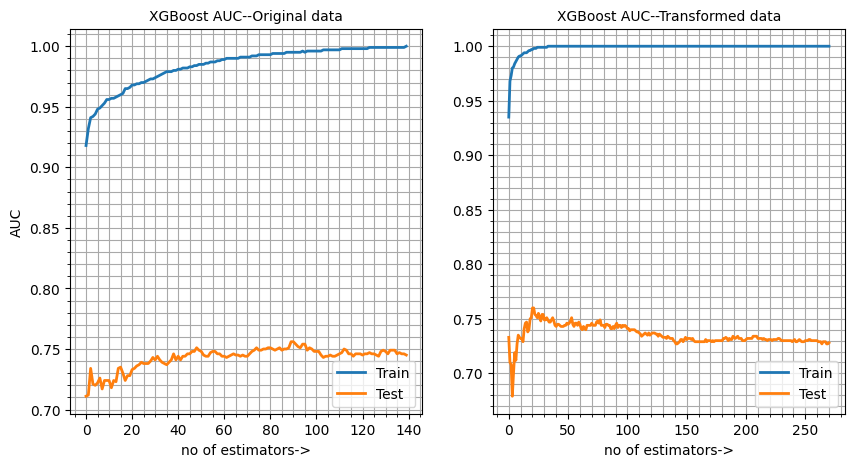

In [103]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5));

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].grid(visible = True, which = 'both', color = "darkgrey")
ax[0].minorticks_on()
ax[0].set_ylabel('AUC');
ax[0].set_xlabel('no of estimators->')
ax[0].set_title("XGBoost AUC--Original data", fontsize = 10)

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].set_xlabel('no of estimators->')
ax[1].grid(visible = True, which = 'both', color = "darkgrey")
ax[1].minorticks_on()
ax[1].set_title('XGBoost AUC--Transformed data', fontsize = 10);
plt.show();

## Feature importance of transformed features:
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [57]:
# 8.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]  # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
eig_Glucose_ck_SkinThickness_p_BMI,0.024832
deg_Glucose_ck_SkinThickness_p_Insulin,0.019391
eig_DiabetesPedigreeFunction_ck_Glucose_p_SkinThickness,0.014157
clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction,0.013938
eig_DiabetesPedigreeFunction_ck_BloodPressure_p_BMI,0.013564




== Column-list whose feat impt >0 =======



['eig_Glucose_ck_SkinThickness_p_BMI',
 'deg_Glucose_ck_SkinThickness_p_Insulin',
 'eig_DiabetesPedigreeFunction_ck_Glucose_p_SkinThickness',
 'clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction',
 'eig_DiabetesPedigreeFunction_ck_BloodPressure_p_BMI']



===Column-list whose feat impt is 0 =======



['eig_Glucose_ck_DiabetesPedigreeFunction',
 'clu_BloodPressure_ck_DiabetesPedigreeFunction',
 'bet_Glucose_ck_BloodPressure',
 'clu_Glucose_ck_BloodPressure',
 'bet_DiabetesPedigreeFunction_ck_BloodPressure_p_BMI']

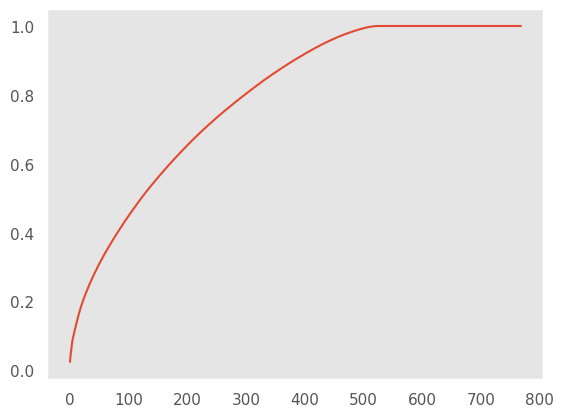

In [58]:
# 8.1 Cumulative sum of feature importance.

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

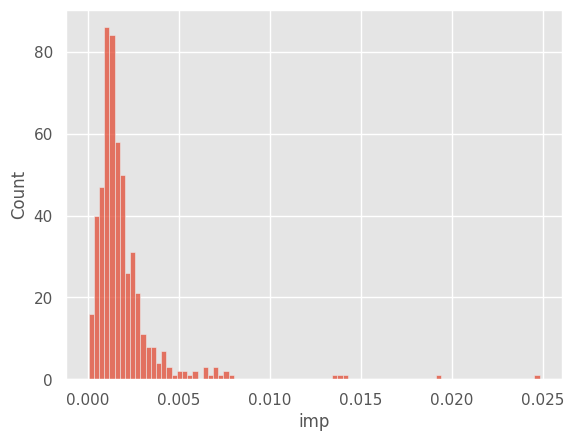

In [59]:
# 8.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.0040

sns.histplot(fe['imp'][fe_1]);

## PCAs with original data and with with transformed data:

In [60]:
# 9.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(692, 2)

In [61]:
# 9.1 PCA with transformed train data.
#     Only consider imp features after xgboost modeling

trans_pca = train_trans[fe_1]
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(692, 2)

In [62]:
# 9.2 Assign column names in Dataframe;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

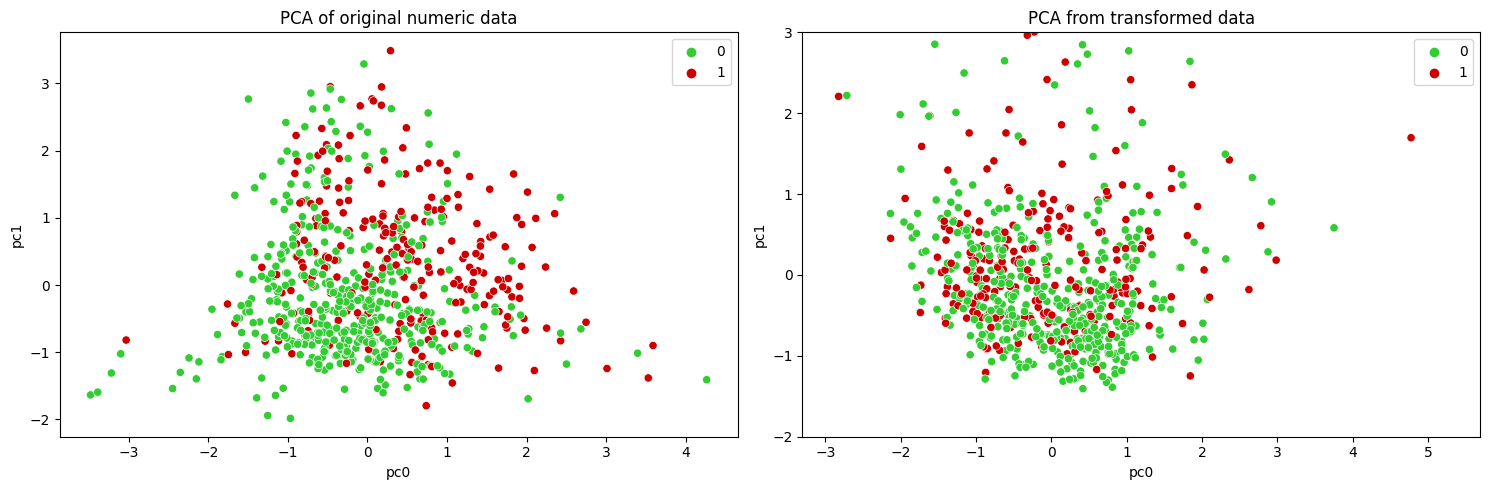

In [67]:
# 9.3 2D PCA plot from original train data:
fig = plt.figure(figsize = (15,5));
fig.add_subplot(1,2,1);
plt.style.use("default");
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');

# 9.4 2D PCA plot from transformed train data:

fig.add_subplot(1,2,2);
plt.style.use("default");
plt.ylim(-2,3)
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();




## Correlation of transformed data with orig columns
Correlation of extracted features with original features

In [68]:
# 10.0 Take top 10 imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (692, 10)

(692, 5)

In [69]:
# 11.1 Reindex orig_train (ie numeric) and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows some degree of correlation between the two sets of features

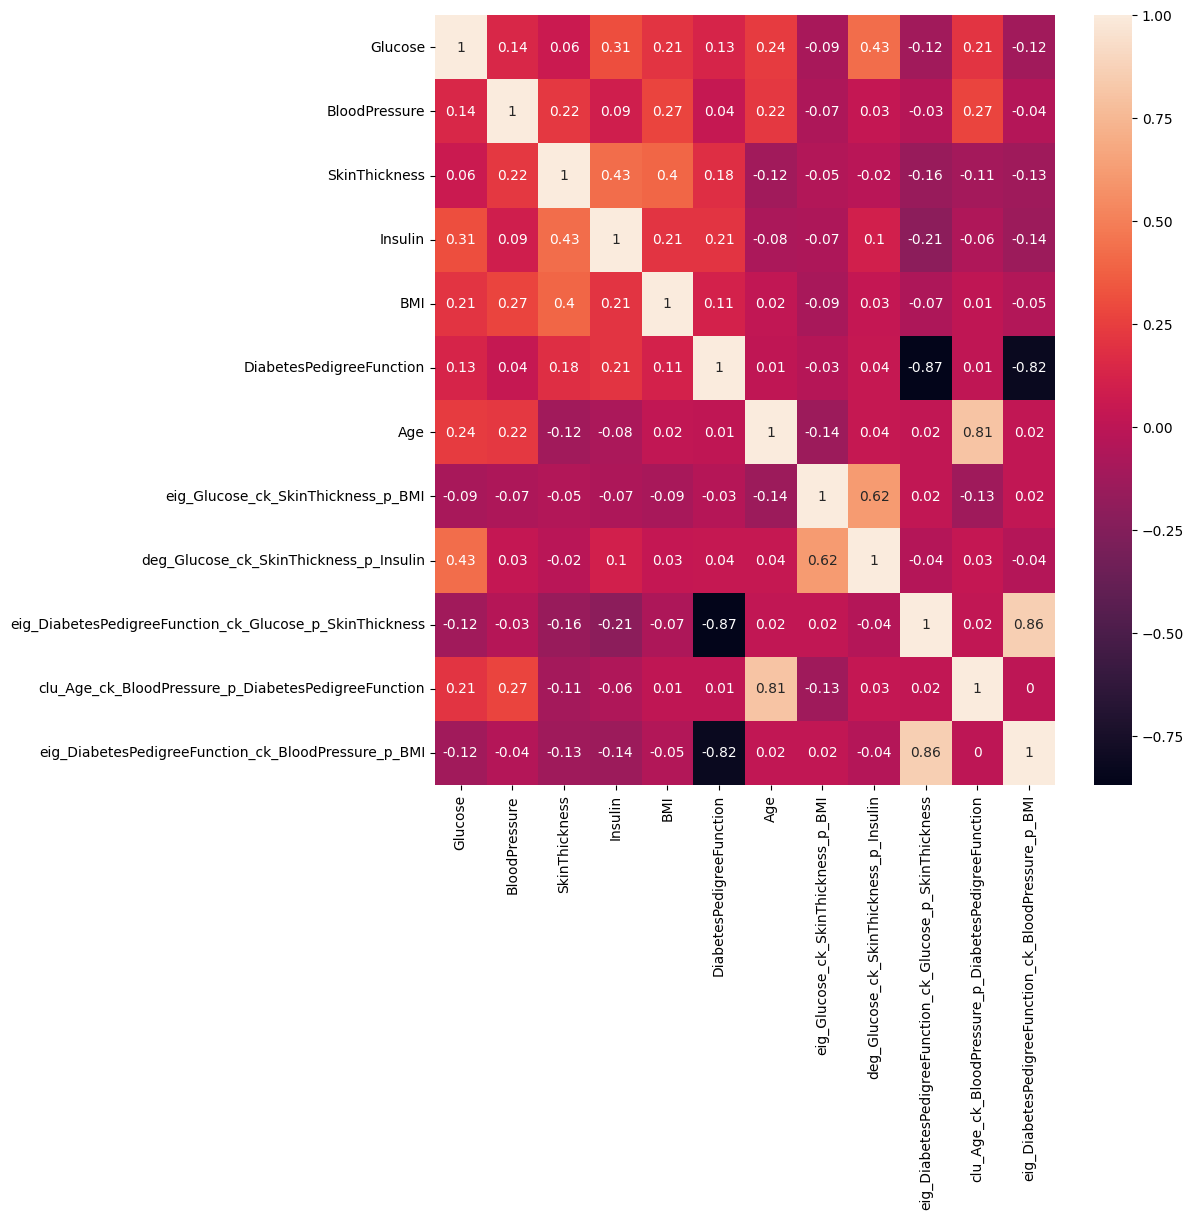

In [70]:
# 11.2 Correlation heatmap:
plt.figure(figsize = (10,10))
sns.heatmap(np.round(result.corr(),2), annot = True) ;

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

eigenvector          0.245774
degree               0.188557
pagerank             0.188557
clusteringcoeff      0.188557
betweenness          0.188557
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

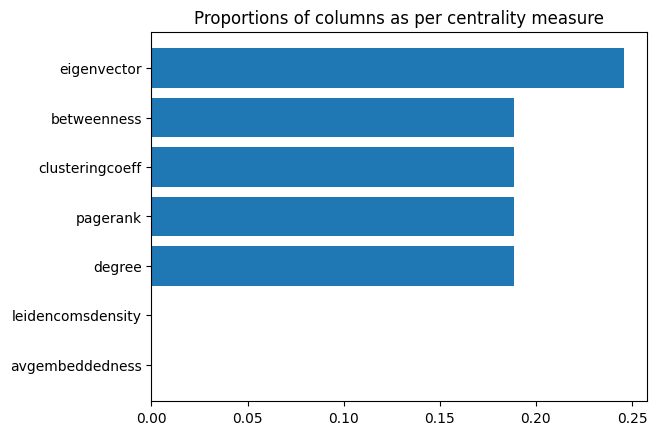

In [71]:
# 12.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [72]:
# 12.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 524'

'Columns whose impt is 0: 245'

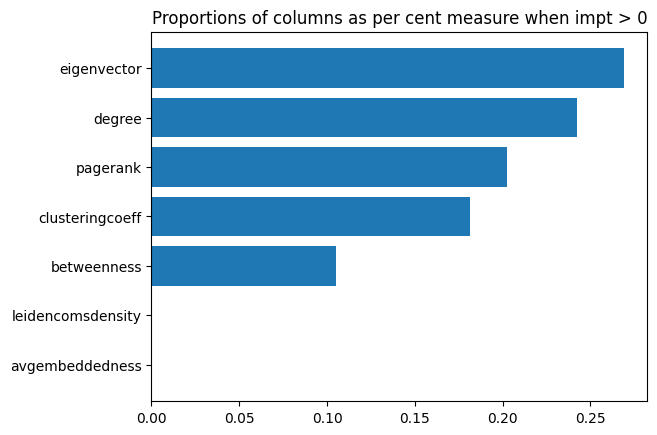

In [73]:
# 12.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [74]:
# 13.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [75]:
# 13.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

eig_Glucose_ck_SkinThickness_p_BMI                         0.024832
deg_Glucose_ck_SkinThickness_p_Insulin                     0.019391
eig_DiabetesPedigreeFunction_ck_Glucose_p_SkinThickness    0.014157
clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction        0.013938
eig_DiabetesPedigreeFunction_ck_BloodPressure_p_BMI        0.013564
Name: imp, dtype: float32

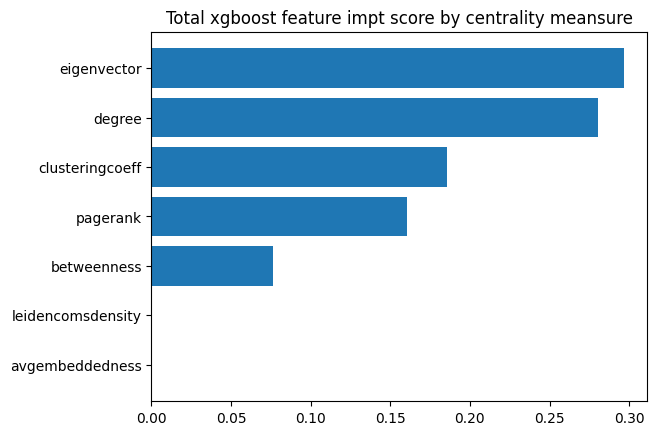

In [76]:
# 13.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [77]:
# 15.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [78]:
# 15.1 Path where .gml files are placed:

filelist = sorted(list(graphfolder.iterdir()))
filelist[:5]   # a_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/Age_bigraph_BMI.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/Age_bigraph_BMI_p_Age.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/Age_bigraph_BMI_p_DiabetesPedigreeFunction.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/Age_bigraph_BloodPressure.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/diabetes/models/Age_bigraph_BloodPressure_p_Age.gml')]

### Read data files from gdrive:

In [81]:
# 16.0
orig_test = pd.read_pickle(datafolder / "orig_test.pkl")
orig_train = pd.read_pickle(datafolder / "orig_train.pkl")
train_binned = pd.read_pickle(datafolder / "train_binned.pkl")
test_binned = pd.read_pickle(datafolder / "test_binned.pkl")
train_trans = pd.read_pickle(datafolder / "train_trans.pkl")
test_trans = pd.read_pickle(datafolder / "test_trans.pkl")
cat_cols = ['Glucose','BloodPressure','SkinThickness','Insulin',
            'BMI','DiabetesPedigreeFunction','Age']
ct = utils.restorePythonObject("transformer.pkl", datafolder)


In [82]:
# 16.1 check data files:
#      All have 'target' col
orig_train.head(2)
orig_test.head(2)
train_binned.head(2)  # Has 'target' column
test_binned.head(2)   # Has 'target' column
train_trans.head(2)
test_trans.head(2)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
68,62.0,78.0,0.0,0.0,32.6,0.391,41.0
460,95.0,72.0,33.0,0.0,37.7,0.370,27.0


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
107,148.0,72.0,35.0,0.0,33.6,0.627,50.0
228,85.0,66.0,29.0,0.0,26.6,0.351,31.0


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
68,410,820,121,161,2015,245,2810,0
460,415,818,1210,161,2017,244,283,0


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
107,423,818,1211,161,2016,248,2815,1
228,413,817,129,161,2012,244,285,0


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Glucose_ck_BloodPressure,eig_Glucose_ck_BloodPressure,pr_Glucose_ck_BloodPressure,...,deg_Age_ck_Glucose_p_SkinThickness,eig_Age_ck_Glucose_p_SkinThickness,pr_Age_ck_Glucose_p_SkinThickness,clu_Age_ck_Glucose_p_SkinThickness,bet_Age_ck_Glucose_p_SkinThickness,deg_Age_ck_BloodPressure_p_Insulin,eig_Age_ck_BloodPressure_p_Insulin,pr_Age_ck_BloodPressure_p_Insulin,clu_Age_ck_BloodPressure_p_Insulin,bet_Age_ck_BloodPressure_p_Insulin
0,410,820,121,161,2015,245,2810,1.0,0.209261,0.043627,...,0.846154,0.216671,0.042596,0.857143,0.008523,0.961538,0.206771,0.040605,0.906667,0.007551
1,415,818,1210,161,2017,244,283,1.0,0.209261,0.043627,...,0.884615,0.223830,0.044383,0.833992,0.011562,1.000000,0.209317,0.042452,0.855385,0.016152


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Glucose_ck_BloodPressure,eig_Glucose_ck_BloodPressure,pr_Glucose_ck_BloodPressure,...,deg_Age_ck_Glucose_p_SkinThickness,eig_Age_ck_Glucose_p_SkinThickness,pr_Age_ck_Glucose_p_SkinThickness,clu_Age_ck_Glucose_p_SkinThickness,bet_Age_ck_Glucose_p_SkinThickness,deg_Age_ck_BloodPressure_p_Insulin,eig_Age_ck_BloodPressure_p_Insulin,pr_Age_ck_BloodPressure_p_Insulin,clu_Age_ck_BloodPressure_p_Insulin,bet_Age_ck_BloodPressure_p_Insulin
0,423,818,1211,161,2016,248,2815,1.0,0.209261,0.043627,...,0.807692,0.21056,0.040797,0.890476,0.005912,0.923077,0.203486,0.038906,0.956522,0.002081
1,413,817,129,161,2012,244,285,1.0,0.209261,0.043627,...,0.884615,0.22219,0.044449,0.822134,0.012828,0.961538,0.206771,0.040605,0.906667,0.007551


### Display graphs

In [83]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'Age_projected' in str(i)]

bigraph = [str(i).split("/")[-1] for i in filelist if 'Age_bigraph' in str(i)]
sb = sorted(bigraph, key=len)
sb[:5]   # bigraph files
print("\n\n====\n")
sp = sorted(projected, key=len)
sp[:5]    # projected graph files

['Age_bigraph_BMI.gml',
 'Age_bigraph_Glucose.gml',
 'Age_bigraph_Insulin.gml',
 'Age_bigraph_BMI_p_Age.gml',
 'Age_bigraph_BloodPressure.gml']



====



['Age_projected_BMI.gml',
 'Age_projected_Glucose.gml',
 'Age_projected_Insulin.gml',
 'Age_projected_BMI_p_Age.gml',
 'Age_projected_BloodPressure.gml']

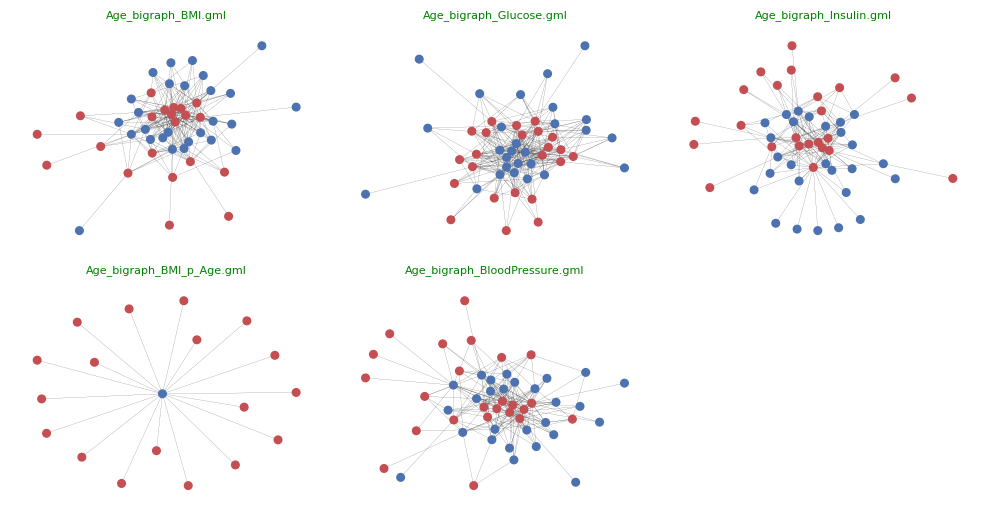

In [85]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for i in sb[:5]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=utils.plotBipartiteGraph(i,graphfolder, ax = ax, title = i, connected = True);
    plt.tight_layout();

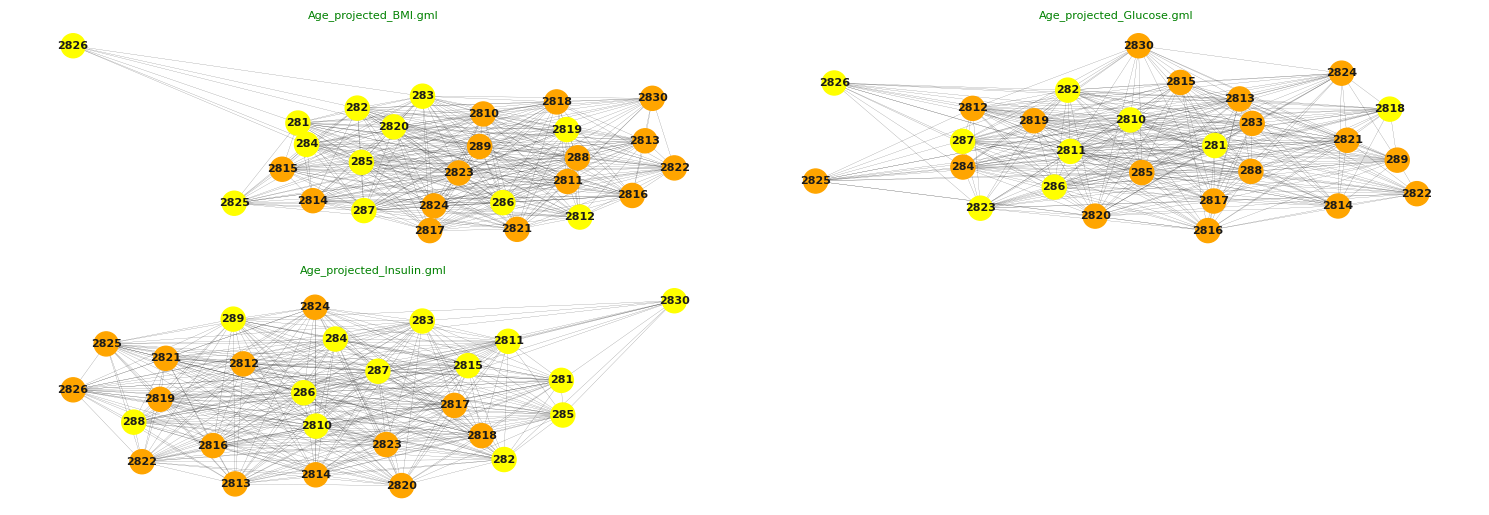

In [86]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for i in sp[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=utils.communityVisualization(i,graphfolder, ax = ax, withLabels = True, title = i);
    plt.tight_layout();

## Transform binned data to communities:

In [87]:
train_binned.columns  # HAs 'target'

Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'target'],
      dtype='object')

In [88]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binnedd cols are:
columnNames = train_binned.columns[:-1]

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
#pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 Perform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(columnNames,graphfolder,train_binned,algo)
  _,df_te = utils.transformBinnedDF2Communities(columnNames,graphfolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

Reading file:  Glucose_projected_BloodPressure.gml
Reading file:  Glucose_projected_SkinThickness.gml
Reading file:  Glucose_projected_Insulin.gml
Reading file:  Glucose_projected_BMI.gml
Reading file:  Glucose_projected_DiabetesPedigreeFunction.gml
Reading file:  Glucose_projected_Age.gml
Reading file:  BloodPressure_projected_Glucose.gml
Reading file:  BloodPressure_projected_SkinThickness.gml
Reading file:  BloodPressure_projected_Insulin.gml
Reading file:  BloodPressure_projected_BMI.gml
Reading file:  BloodPressure_projected_DiabetesPedigreeFunction.gml
Reading file:  BloodPressure_projected_Age.gml
Reading file:  SkinThickness_projected_Glucose.gml
Reading file:  SkinThickness_projected_BloodPressure.gml
Reading file:  SkinThickness_projected_Insulin.gml
Reading file:  SkinThickness_projected_BMI.gml
Reading file:  SkinThickness_projected_DiabetesPedigreeFunction.gml
Reading file:  SkinThickness_projected_Age.gml
Reading file:  Insulin_projected_Glucose.gml
Reading file:  Insulin

In [90]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].shape   # (692, 42)
fg_tr[0].head(3)
fg_te[0].head(3)


(692, 42)

,Glucose_projected_BloodPressure.gml,Glucose_projected_SkinThickness.gml,Glucose_projected_Insulin.gml,Glucose_projected_BMI.gml,Glucose_projected_DiabetesPedigreeFunction.gml,Glucose_projected_Age.gml,BloodPressure_projected_Glucose.gml,BloodPressure_projected_SkinThickness.gml,BloodPressure_projected_Insulin.gml,BloodPressure_projected_BMI.gml,...,DiabetesPedigreeFunction_projected_SkinThickness.gml,DiabetesPedigreeFunction_projected_Insulin.gml,DiabetesPedigreeFunction_projected_BMI.gml,DiabetesPedigreeFunction_projected_Age.gml,Age_projected_Glucose.gml,Age_projected_BloodPressure.gml,Age_projected_SkinThickness.gml,Age_projected_Insulin.gml,Age_projected_BMI.gml,Age_projected_DiabetesPedigreeFunction.gml
68,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,1,0,1
460,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
224,0,0,0,0,0,0,1,1,1,1,...,0,1,1,0,0,1,0,1,1,0


,Glucose_projected_BloodPressure.gml,Glucose_projected_SkinThickness.gml,Glucose_projected_Insulin.gml,Glucose_projected_BMI.gml,Glucose_projected_DiabetesPedigreeFunction.gml,Glucose_projected_Age.gml,BloodPressure_projected_Glucose.gml,BloodPressure_projected_SkinThickness.gml,BloodPressure_projected_Insulin.gml,BloodPressure_projected_BMI.gml,...,DiabetesPedigreeFunction_projected_SkinThickness.gml,DiabetesPedigreeFunction_projected_Insulin.gml,DiabetesPedigreeFunction_projected_BMI.gml,DiabetesPedigreeFunction_projected_Age.gml,Age_projected_Glucose.gml,Age_projected_BloodPressure.gml,Age_projected_SkinThickness.gml,Age_projected_Insulin.gml,Age_projected_BMI.gml,Age_projected_DiabetesPedigreeFunction.gml
107,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0.0,1.0,1.0,0.0,0,0,1,1,0,0
228,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0.0,1.0,0.0,0.0,0,1,0,1,1,0
0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0.0,1.0,1.0,0.0,1,0,0,1,1,0


In [91]:
# Remove constant cols
# https://stackoverflow.com/a/20210048
fg_tr[0] = fg_tr[0].loc[:, (fg_tr[0] != fg_tr[0].iloc[0]).any()]
fg_te[0] = fg_te[0][fg_tr[0].columns]

In [92]:
fg_tr[0].shape  # (692, 33)
fg_te[0].shape  # (76, 33)

(692, 33)

(76, 33)

### Save Community data

In [106]:
# 19.0.2
utils.savePythonObject(fg_tr, "fg_tr.pkl", datafolder)
utils.savePythonObject(fg_te,"fg_te.pkl", datafolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/diabetes/data/fg_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/diabetes/data/fg_te.pkl


### Restore Community data

In [107]:
# 19.0.3
fg_tr = utils.restorePythonObject("fg_tr.pkl", datafolder)
fg_te = utils.restorePythonObject("fg_te.pkl", datafolder)

In [93]:
# 18.6 Extract target columns:

ytr = y_train = train_binned['target']
yte = y_test = test_binned['target']

### xgboost modeling from community indicators:

In [94]:
# 19.0 Modeling with transformed train/test data with community indicators:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 200,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[05:00:24] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[05:00:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation_0-auc:0.85633	validation_1-auc:0.76065
[05:00:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation_0-auc:0.87982	validation_1-auc:0.74716
[05:00:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.89995	validation_1-auc:0.78196
[05:00:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.90958	validation_1-auc:0.77379
[05:00:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=11
[4]	validation_0-auc:0.91497	validation_1-auc:0.75781
[05:00:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned no

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

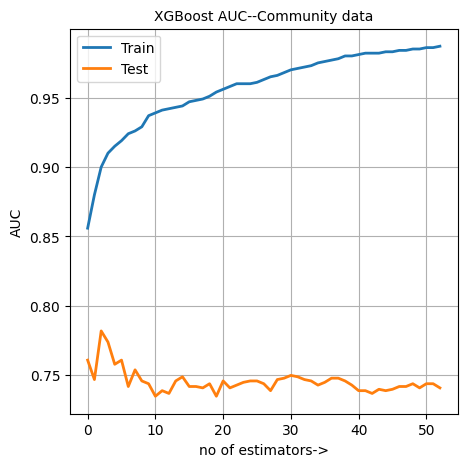

In [100]:
# 9.3 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.figure(figsize = (5,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Community data", fontsize = 10);


### PCA of transformed data:

In [104]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,BloodPressure_projected_Glucose.gml,BloodPressure_projected_SkinThickness.gml,BloodPressure_projected_Insulin.gml,BloodPressure_projected_BMI.gml,BloodPressure_projected_DiabetesPedigreeFunction.gml,BloodPressure_projected_Age.gml,SkinThickness_projected_BMI.gml,SkinThickness_projected_DiabetesPedigreeFunction.gml,SkinThickness_projected_Age.gml,Insulin_projected_Glucose.gml,...,DiabetesPedigreeFunction_projected_SkinThickness.gml,DiabetesPedigreeFunction_projected_Insulin.gml,DiabetesPedigreeFunction_projected_BMI.gml,DiabetesPedigreeFunction_projected_Age.gml,Age_projected_Glucose.gml,Age_projected_BloodPressure.gml,Age_projected_SkinThickness.gml,Age_projected_Insulin.gml,Age_projected_BMI.gml,Age_projected_DiabetesPedigreeFunction.gml
68,0,0,0,0,0,2,0,0,1,1,...,1,1,0,0,1,1,0,1,0,1
460,0,0,0,0,0,1,0,0,1,1,...,0,1,0,0,0,1,0,1,1,0
224,1,1,1,1,0,1,0,0,1,1,...,0,1,1,0,0,1,0,1,1,0


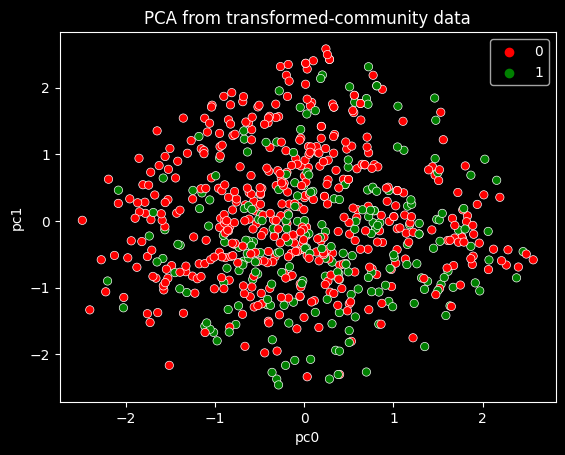

In [108]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

### REad data

In [111]:
# 16.0
orig_test = pd.read_pickle(datafolder / "orig_test.pkl")
orig_train = pd.read_pickle(datafolder / "orig_train.pkl")
train_binned = pd.read_pickle(datafolder / "train_binned.pkl")
test_binned = pd.read_pickle(datafolder / "test_binned.pkl")
train_trans = pd.read_pickle(datafolder / "train_trans.pkl")
test_trans = pd.read_pickle(datafolder / "test_trans.pkl")
cat_cols = ['Glucose','BloodPressure','SkinThickness','Insulin',
            'BMI','DiabetesPedigreeFunction','Age']
ct = utils.restorePythonObject("transformer.pkl", datafolder)


In [112]:
# 21.2 Check for nulls:
train_trans.isnull().sum().sum()  # 0
print("---")
test_trans.isnull().sum().sum()   # 436

0

---


436

In [113]:
# 21.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [114]:
'target' in list(train_trans.columns)
'target' in list(test_trans.columns)

False

False

In [115]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [116]:
# 22.0 Derive unit vectors:

p = Path(unitvecfolder)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 22.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = unitvecfolder,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for Glucose
Checked for BloodPressure
Checked for SkinThickness
Checked for Insulin
Checked for BMI
Checked for DiabetesPedigreeFunction
Checked for Age
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/diabetes/unitvecfolder'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for Glucose
Checked for BloodPressure
Checked for SkinThickness
Checked for Insulin
Checked for BMI
Checked for DiabetesPedigreeFunction
Checked for Age


## Save unit-vectors files to gdrive
Also save output dictionaries for later use

In [118]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", unitvecfolder)
utils.savePythonObject(vec_te, "vec_te.pkl",unitvecfolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/diabetes/unitvecfolder/vec_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/diabetes/unitvecfolder/vec_te.pkl


## Restore unit-vectors files from gdrive

In [119]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", unitvecfolder)
vec_te = utils.restorePythonObject("vec_te.pkl",unitvecfolder)

## Using unit vectors to transform train/test data

In [120]:
# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for Glucose for train data
Performing PCA for Glucose for test data
Performing PCA for BloodPressure for train data
Performing PCA for BloodPressure for test data
Performing PCA for SkinThickness for train data
Performing PCA for SkinThickness for test data
Performing PCA for Insulin for train data
Performing PCA for Insulin for test data
Performing PCA for BMI for train data
Performing PCA for BMI for test data
Performing PCA for DiabetesPedigreeFunction for train data
Performing PCA for DiabetesPedigreeFunction for test data
Performing PCA for Age for train data
Performing PCA for Age for test data
Concatenating train data
Concatenating test data
Done......


In [121]:
# 23.1

cctr.head(3)
ccte.head(3)

,pcGlucose0,pcGlucose1,pcGlucose2,pcGlucose3,pcBloodPressure0,pcBloodPressure1,pcBloodPressure2,pcBloodPressure3,pcSkinThickness0,pcSkinThickness1,...,pcBMI2,pcBMI3,pcDiabetesPedigreeFunction0,pcDiabetesPedigreeFunction1,pcDiabetesPedigreeFunction2,pcDiabetesPedigreeFunction3,pcAge0,pcAge1,pcAge2,pcAge3
0,37.482891,-2.226228,-6.096470,15.680329,-4.483729,2.879388,1.520053,-1.309845,-6.182230,4.788535,...,-0.545458,1.822810,-1.111648,-1.635096,0.993930,1.191225,2.025680,-2.432304,-0.201468,0.507281
1,-4.663655,0.512640,0.214873,0.831058,-5.700006,0.525486,1.649191,4.486151,-4.190142,-3.817550,...,1.162016,0.516195,-3.716597,-0.724245,3.155482,-1.881334,-2.011795,0.095423,0.604919,0.142966
2,-4.421197,0.386290,-0.926643,1.114072,4.115617,3.860908,3.224618,-2.489288,-6.182230,4.788528,...,1.146274,-1.495393,-7.743514,4.839404,-2.080798,-0.552117,-2.011795,0.095428,0.604911,0.142973


,pcGlucose0,pcGlucose1,pcGlucose2,pcGlucose3,pcBloodPressure0,pcBloodPressure1,pcBloodPressure2,pcBloodPressure3,pcSkinThickness0,pcSkinThickness1,...,pcBMI2,pcBMI3,pcDiabetesPedigreeFunction0,pcDiabetesPedigreeFunction1,pcDiabetesPedigreeFunction2,pcDiabetesPedigreeFunction3,pcAge0,pcAge1,pcAge2,pcAge3
0,0.543970,-3.957317,2.164244,-1.836050,-5.700008,0.525482,1.649190,4.486151,4.140262,-0.781117,...,1.610936,-0.244182,1.685842,-2.362666,-0.413342,0.537370,8.812095,1.311930,0.907943,-3.991567
1,-1.510863,0.821288,-1.395040,1.245898,-0.694511,-3.119650,2.154635,-0.492314,-0.878415,-2.308422,...,-1.632268,-0.424972,-3.716593,-0.724244,3.155483,-1.881341,-1.071766,-3.652193,0.005334,1.946163
2,12.347978,-6.378557,4.917311,-0.514775,-3.540748,0.210889,-0.421459,-1.540222,-6.182224,4.788526,...,0.060967,-0.741154,1.685842,-2.362666,-0.413342,0.537370,4.922146,-1.657337,-1.119719,-0.318390


In [129]:
# 23.2

cctr.shape   #  (692, 28)
ccte.shape   #  (76, 28)

(692, 28)

(76, 28)

In [131]:
# 23.3

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:20]))
print(list(cctr.columns[20:30]))





['pcGlucose0', 'pcGlucose1', 'pcGlucose2', 'pcGlucose3', 'pcBloodPressure0', 'pcBloodPressure1', 'pcBloodPressure2', 'pcBloodPressure3', 'pcSkinThickness0', 'pcSkinThickness1']
['pcSkinThickness2', 'pcSkinThickness3', 'pcInsulin0', 'pcInsulin1', 'pcInsulin2', 'pcInsulin3', 'pcBMI0', 'pcBMI1', 'pcBMI2', 'pcBMI3']
['pcDiabetesPedigreeFunction0', 'pcDiabetesPedigreeFunction1', 'pcDiabetesPedigreeFunction2', 'pcDiabetesPedigreeFunction3', 'pcAge0', 'pcAge1', 'pcAge2', 'pcAge3']


### Save unitvectors transformed train/test

In [132]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(datafolder / "cctr.pkl")
ccte.to_pickle(datafolder / "ccte.pkl")

### Readback unitvectors transformed train/test

In [133]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(datafolder / "cctr.pkl")
ccte = pd.read_pickle(datafolder / "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (692, 28)
ccte.shape # (76, 28)

,pcGlucose0,pcGlucose1,pcGlucose2,pcGlucose3,pcBloodPressure0,pcBloodPressure1,pcBloodPressure2,pcBloodPressure3,pcSkinThickness0,pcSkinThickness1,...,pcBMI2,pcBMI3,pcDiabetesPedigreeFunction0,pcDiabetesPedigreeFunction1,pcDiabetesPedigreeFunction2,pcDiabetesPedigreeFunction3,pcAge0,pcAge1,pcAge2,pcAge3
0,37.482891,-2.226228,-6.096470,15.680329,-4.483729,2.879388,1.520053,-1.309845,-6.182230,4.788535,...,-0.545458,1.822810,-1.111648,-1.635096,0.993930,1.191225,2.025680,-2.432304,-0.201468,0.507281
1,-4.663655,0.512640,0.214873,0.831058,-5.700006,0.525486,1.649191,4.486151,-4.190142,-3.817550,...,1.162016,0.516195,-3.716597,-0.724245,3.155482,-1.881334,-2.011795,0.095423,0.604919,0.142966


,pcGlucose0,pcGlucose1,pcGlucose2,pcGlucose3,pcBloodPressure0,pcBloodPressure1,pcBloodPressure2,pcBloodPressure3,pcSkinThickness0,pcSkinThickness1,...,pcBMI2,pcBMI3,pcDiabetesPedigreeFunction0,pcDiabetesPedigreeFunction1,pcDiabetesPedigreeFunction2,pcDiabetesPedigreeFunction3,pcAge0,pcAge1,pcAge2,pcAge3
0,0.543970,-3.957317,2.164244,-1.836050,-5.700008,0.525482,1.649190,4.486151,4.140262,-0.781117,...,1.610936,-0.244182,1.685842,-2.362666,-0.413342,0.537370,8.812095,1.311930,0.907943,-3.991567
1,-1.510863,0.821288,-1.395040,1.245898,-0.694511,-3.119650,2.154635,-0.492314,-0.878415,-2.308422,...,-1.632268,-0.424972,-3.716593,-0.724244,3.155483,-1.881341,-1.071766,-3.652193,0.005334,1.946163


(692, 28)

(76, 28)

## xgboost modeling

In [142]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 5,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[06:01:36] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:01:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.85429	validation_1-auc:0.61896
[06:01:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.87835	validation_1-auc:0.65945
[06:01:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-auc:0.89039	validation_1-auc:0.70384
[06:01:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.89870	validation_1-auc:0.71626
[06:01:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[4]	validation_0-auc:0.89936	validation_1-auc:0.72159
[06:01:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 44 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [143]:
# 24.2 Best scores:

model_vec.best_score   #0.72869318181
print("\n")
model_vec.best_iteration  # 4


0.7521306818181818

47

In [144]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        44
           1       0.61      0.53      0.57        32

    accuracy                           0.66        76
   macro avg       0.65      0.64      0.64        76
weighted avg       0.65      0.66      0.65        76



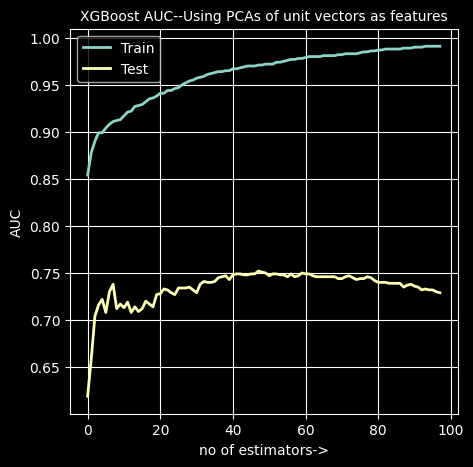

In [145]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);


## Feature Engineering with clustering

In [146]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 4,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24


In [147]:
# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

,pcGlucose0,pcGlucose1,pcGlucose2,pcGlucose3,pcBloodPressure0,pcBloodPressure1,pcBloodPressure2,pcBloodPressure3,pcSkinThickness0,pcSkinThickness1,...,pcAge1,pcAge2,pcAge3,clu0,clu1,clu2,clu3,clu4,clu5,clu6
0,37.482891,-2.226228,-6.096470,15.680329,-4.483729,2.879388,1.520053,-1.309845,-6.182230,4.788535,...,-2.432304,-0.201468,0.507281,3,1,0,0,1,0,1
1,-4.663655,0.512640,0.214873,0.831058,-5.700006,0.525486,1.649191,4.486151,-4.190142,-3.817550,...,0.095423,0.604919,0.142966,0,1,1,0,0,0,1
2,-4.421197,0.386290,-0.926643,1.114072,4.115617,3.860908,3.224618,-2.489288,-6.182230,4.788528,...,0.095428,0.604911,0.142973,0,2,0,0,1,1,1


,pcGlucose0,pcGlucose1,pcGlucose2,pcGlucose3,pcBloodPressure0,pcBloodPressure1,pcBloodPressure2,pcBloodPressure3,pcSkinThickness0,pcSkinThickness1,...,pcAge1,pcAge2,pcAge3,clu0,clu1,clu2,clu3,clu4,clu5,clu6
0,0.543970,-3.957317,2.164244,-1.836050,-5.700008,0.525482,1.649190,4.486151,4.140262,-0.781117,...,1.311930,0.907943,-3.991567,0,1,1,0,0,0,0
1,-1.510863,0.821288,-1.395040,1.245898,-0.694511,-3.119650,2.154635,-0.492314,-0.878415,-2.308422,...,-3.652193,0.005334,1.946163,0,2,1,0,1,0,1
2,12.347978,-6.378557,4.917311,-0.514775,-3.540748,0.210889,-0.421459,-1.540222,-6.182224,4.788526,...,-1.657337,-1.119719,-0.318390,1,1,0,0,1,0,1


In [148]:
# 25.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()


,clu0,clu1,clu2,clu3,clu4,clu5,clu6
0,3,1,0,0,1,0,1
1,0,1,1,0,0,0,1
2,0,2,0,0,1,1,1
3,0,2,1,0,1,1,1
4,0,3,1,0,1,0,2


,clu0,clu1,clu2,clu3,clu4,clu5,clu6
0,0,1,1,0,0,0,0
1,0,2,1,0,1,0,1
2,1,1,0,0,1,0,1
3,0,2,1,3,1,0,2
4,0,3,1,3,1,3,1


In [152]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.1,
                              max_depth = 4,
                              subsample = 0.9,
                              random_state = None,
                              #reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[06:06:00] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.74711	validation_1-auc:0.69283
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:0.74300	validation_1-auc:0.68572
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-auc:0.76822	validation_1-auc:0.70597
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-auc:0.77508	validation_1-auc:0.71768
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-auc:0.78199	validation_1-auc:0.72834
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [153]:
model_fe.best_score  # 0.7414772


0.7414772727272727

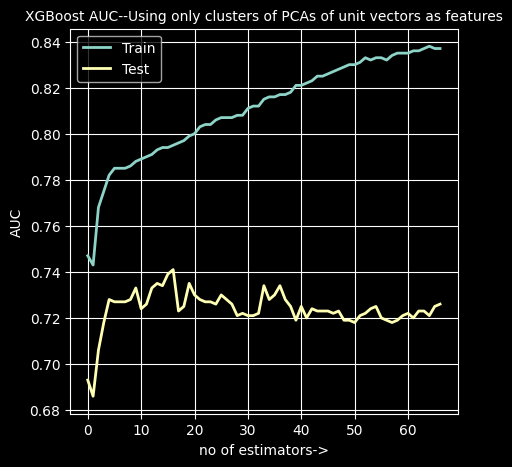

In [154]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);
